# ChromVAR

Run ChromVAR for OSKM selected motifs only.

In [2]:
library(chromVAR)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Matrix)
library(SummarizedExperiment)
library(patchwork)
library(ggplot2)
library(scales)
library(motifmatchr)
library(BiocParallel)
set.seed(2017)



No methods found in package ‘IRanges’ for request: ‘score’ when loading ‘TFBSTools’

Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.ma

In [3]:
register(MulticoreParam(20, progressbar = TRUE))

## Load Data

In [4]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20210717_n62599/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  62599 530910

In [5]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 62599     6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,-1.8037916,-9.507773,1,D0_AAACACGCTAGTACGG
D0_AAACACGCTCTTCAAG,AAACACGCTCTTCAAG,D0,0.7074551,-9.406457,1,D0_AAACACGCTCTTCAAG
D0_AAACACGCTGATCCAT,AAACACGCTGATCCAT,D0,-2.9559933,-7.641148,1,D0_AAACACGCTGATCCAT
D0_AAACCCTGACCGCTAG,AAACCCTGACCGCTAG,D0,-3.6119107,-8.443144,1,D0_AAACCCTGACCGCTAG
D0_AAACCCTGATTGCAGT,AAACCCTGATTGCAGT,D0,0.5002119,-8.759449,3,D0_AAACCCTGATTGCAGT


In [6]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 530910      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr17_32960817_32961317,chr17,32960817,32961317,chr17_32960817_32961317
chr17_75764252_75764752,chr17,75764252,75764752,chr17_75764252_75764752
chr17_1473114_1473614,chr17,1473114,1473614,chr17_1473114_1473614
chr17_4206897_4207397,chr17,4206897,4207397,chr17_4206897_4207397
chr17_423409_423909,chr17,423409,423909,chr17_423409_423909
chr17_1964634_1965134,chr17,1964634,1965134,chr17_1964634_1965134


In [7]:
peaks_gr = GRanges(sub("_", "-", sub("_", ":", rownames(regions))))
peaks_gr

GRanges object with 530910 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]    chr17 32960817-32961317      *
       [2]    chr17 75764252-75764752      *
       [3]    chr17   1473114-1473614      *
       [4]    chr17   4206897-4207397      *
       [5]    chr17     423409-423909      *
       ...      ...               ...    ...
  [530906]     chrY   7260941-7261441      *
  [530907]     chrY 13337357-13337857      *
  [530908]     chrY   7109991-7110491      *
  [530909]     chrY 13241191-13241691      *
  [530910]     chrY   7936006-7936506      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [8]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [9]:
pmatRowSums = Matrix::rowSums(pmat)

In [10]:
pmatColSums = Matrix::colSums(pmat)

In [11]:
min(pmatRowSums)

[1] 487

In [12]:
min(pmatColSums)

[1] 22

## Motifs

In [73]:
O_pfm = as.matrix(read.table("./data/pfms/POU5F1_MA1115.1.pfm"))
S_pfm = t(as.matrix(read.table("./data/pfms/SOX2_HUMAN.H11MO.0.A.pcm")))
K_pfm = t(as.matrix(read.table("./data/pfms/KLF4_HUMAN.H11MO.0.A.pcm")))
M_pfm = t(as.matrix(read.table("./data/pfms/MYC_HUMAN.H11MO.0.A.pcm")))
OS_pfm = as.matrix(read.table("./data/pfms/OCTSOX_MA0142.1.pfm"))

bases = c("A", "C", "G", "T")
rownames(O_pfm) = bases
rownames(S_pfm) = bases
rownames(K_pfm) = bases
rownames(M_pfm) = bases
rownames(OS_pfm) = bases

In [82]:
motifs = PFMatrixList(PFMatrix(name="POU5F1", profileMatrix = O_pfm), 
                      PFMatrix(name="SOX2", profileMatrix = S_pfm),
                      PFMatrix(name="KLF4", profileMatrix = K_pfm),
                      PFMatrix(name="MYC", profileMatrix = M_pfm),
                      PFMatrix(name="POU5F1:SOX2", profileMatrix = OS_pfm))

## ChromVAR

In [83]:
GENOME = BSgenome.Hsapiens.UCSC.hg38

In [84]:
rse <- SummarizedExperiment(
                 assays = list(counts = t(pmat)), 
                 rowRanges = peaks_gr, 
                 colData = DataFrame(Cell_Type=1:nrow(pmat), depth=pmatRowSums)
    );

In [85]:
rse <- addGCBias(rse, genome = GENOME);

In [88]:
motif_ix <- matchMotifs(motifs, rse, 
                        genome = GENOME)

In [89]:
dev <- computeDeviations(object = rse, annotations = motif_ix)

  |======================================================================| 100%



In [90]:
dev_mat = t(assay(dev))

In [132]:
colMeans(motif_ix@assays@data[[1]])

[1] 0.12098661 0.20962875 0.23116347 0.05540487 0.15808894

In [135]:
motif_names = unlist(lapply(motifs, function(x) {x@name}))

In [136]:
colnames(dev_mat) = motif_names
rownames(dev_mat) = rownames(metaData)
head(dev_mat)

,POU5F1,SOX2,KLF4,MYC,POU5F1:SOX2
D0_AAACACGCTAGTACGG,-0.2122726,-0.09810214,-0.11072911,0.07220178,-0.3886107
D0_AAACACGCTCTTCAAG,-0.2213217,-0.04278614,-0.09111312,0.09327532,-0.3022712
D0_AAACACGCTGATCCAT,-0.2494031,-0.07451371,-0.09690176,0.02589021,-0.3666447
D0_AAACCCTGACCGCTAG,-0.1958958,-0.12078850,-0.08822089,0.09043976,-0.3711973
D0_AAACCCTGATTGCAGT,-0.1414688,-0.02213143,-0.07480125,0.16515913,-0.2970046
D0_AAACCGTACACACCTA,-0.2181193,-0.08840394,-0.09823535,0.06612842,-0.3674076


In [158]:
# save output
write.table(dev_mat, file="./sessions/20210717_n62599/OSKM_ChromVAR.tsv", quote=F, row.names=T, sep='\t')

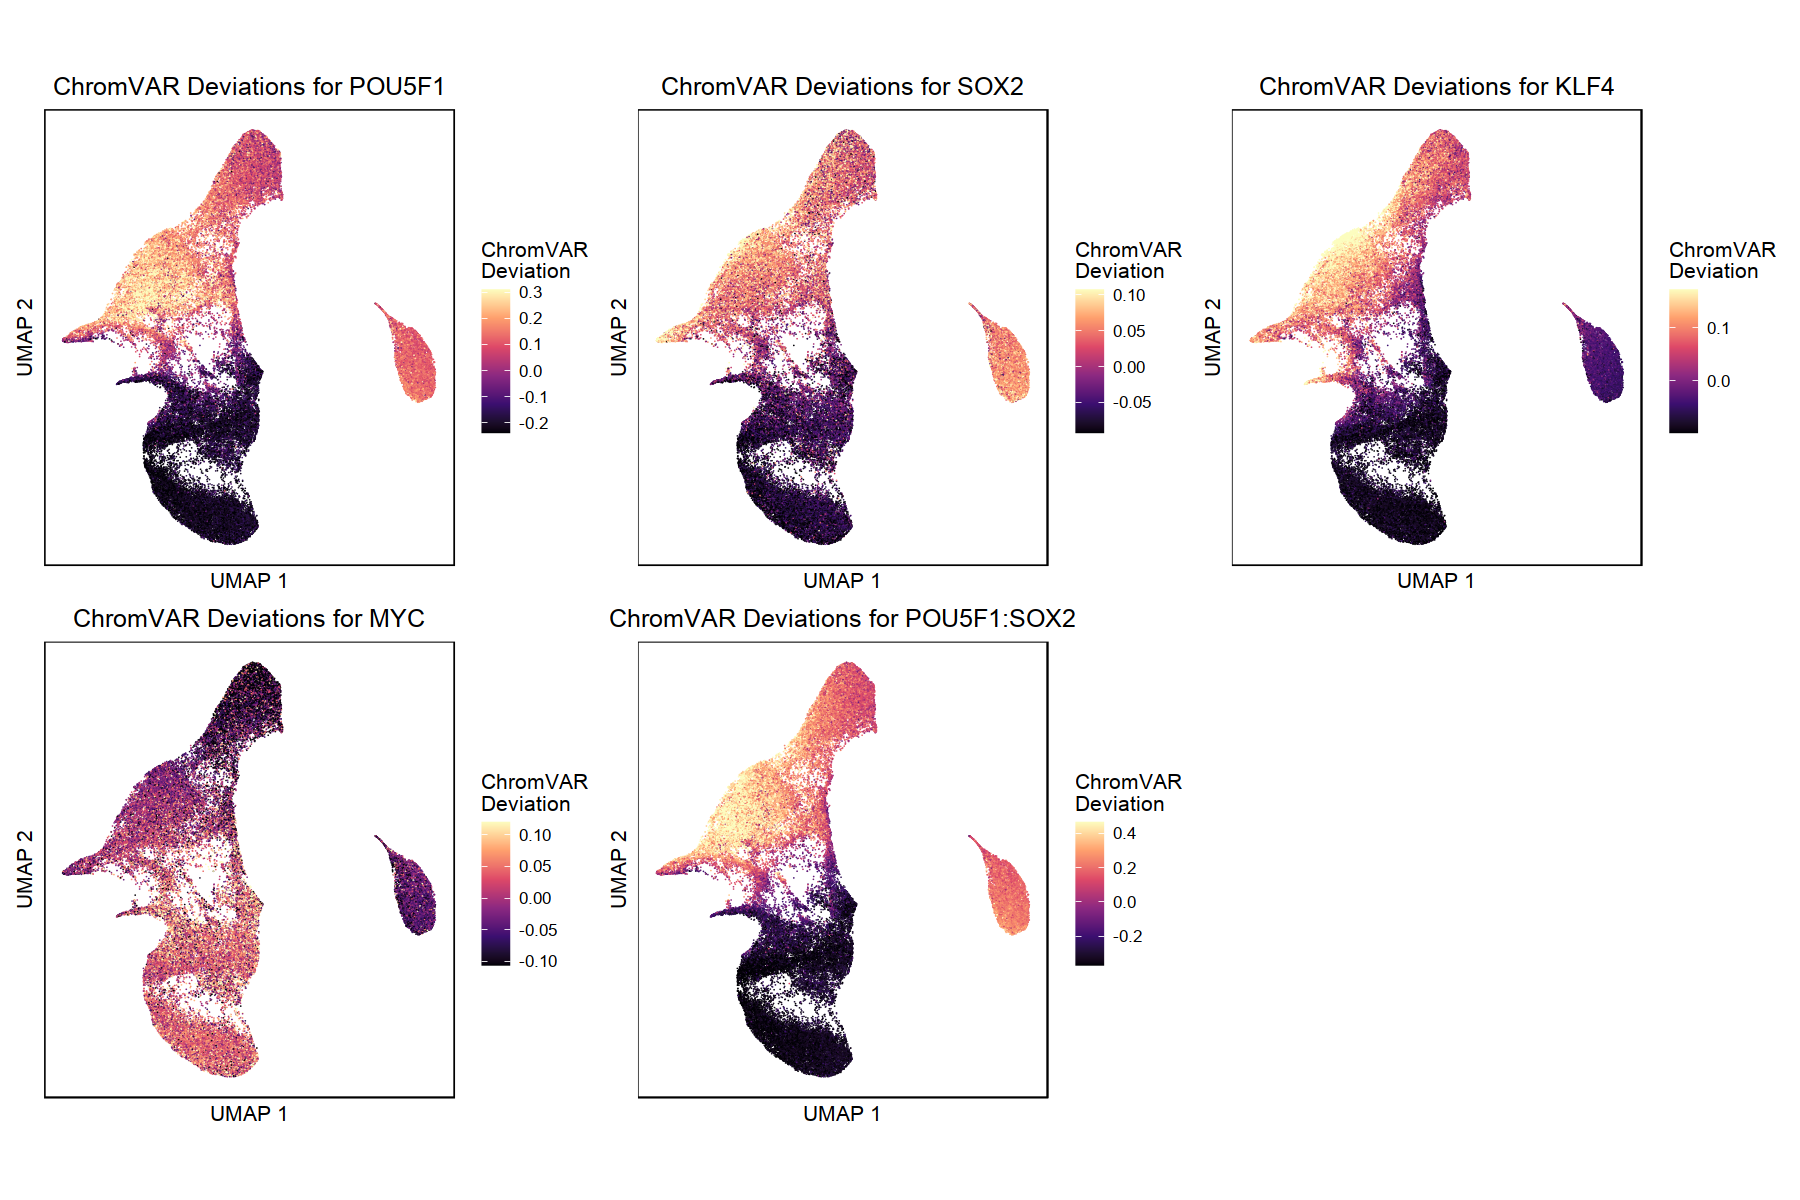

In [137]:
options(repr.plot.width = 15, repr.plot.height = 10)

chromvar_plots = list()

for (i in seq(length(motif_names))) {
    cur_pattern = motif_names[i]
    cur_dev = dev_mat[,cur_pattern]

    df = data.frame(metaData, n=cur_dev)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

    cur_plot <- ggplot(df) +
    geom_point(size=0.2, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
    scale_color_viridis_c(limit=c(quantile(cur_dev, 0.1),
                                  quantile(cur_dev, 0.95)), 
                          oob = squish, name='ChromVAR\nDeviation',
                         option="A") +
    ggtitle(sprintf("ChromVAR Deviations for %s", cur_pattern)) + 
    theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    coord_fixed()
    
    chromvar_plots[[i]] = cur_plot

}

wrap_plots(chromvar_plots, nrow=2)

In [151]:
frips = list()
cors = c()

for (i in seq(length(motif_names))) {
    cur_pattern = motif_names[i]
    
    frips[[i]] = 100*Matrix::rowSums(pmat[, motif_ix@assays@data[[1]][, i]>0])/pmatRowSums
    cors = c(cors, cor(frips[[i]], dev_mat[,cur_pattern], method='spearman'))
}

names(frips) = motif_names
names(cors) = motif_names

# cors between FRiP and ChromVAR
cors

POU5F1        SOX2        KLF4         MYC POU5F1:SOX2 
  0.8606281   0.7789217   0.7669005   0.8491687   0.8883373

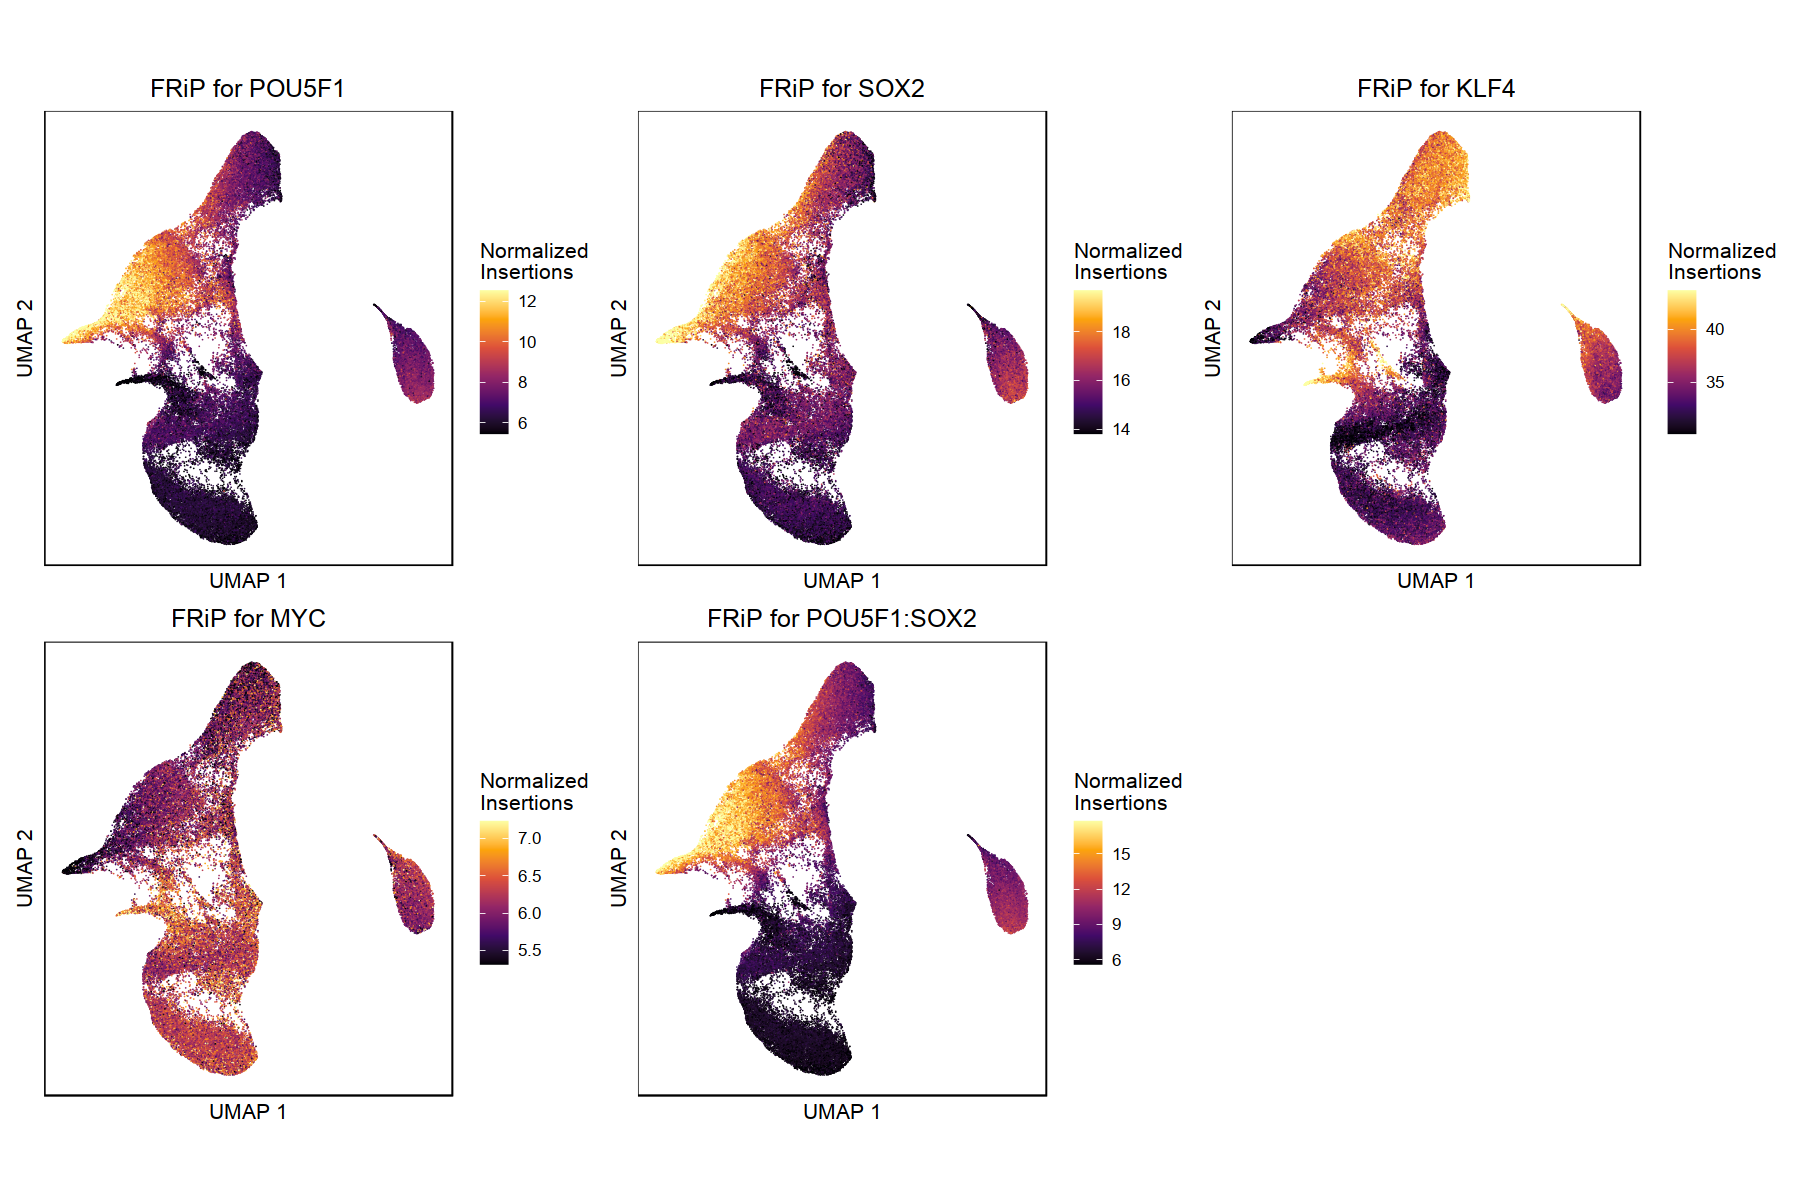

In [153]:
options(repr.plot.width = 15, repr.plot.height = 10)

frip_plots = list()

for (i in seq(length(motif_names))) {
    cur_pattern = motif_names[i]

    df = data.frame(metaData, n=frips[[i]])
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

    cur_plot <- ggplot(df) +
        geom_point(size=0.2, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
        scale_color_viridis_c(limit=c(quantile(frips[[i]], 0.05),
                                      quantile(frips[[i]], 0.98)), 
                              oob = squish, option="B",
                             name="Normalized\nInsertions") +
        theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
        theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
        ggtitle(sprintf("FRiP for %s", cur_pattern)) + 
        theme(plot.title = element_text(hjust = 0.5)) +
        coord_fixed()
    
    frip_plots[[i]] = cur_plot

}

wrap_plots(frip_plots, nrow=2)

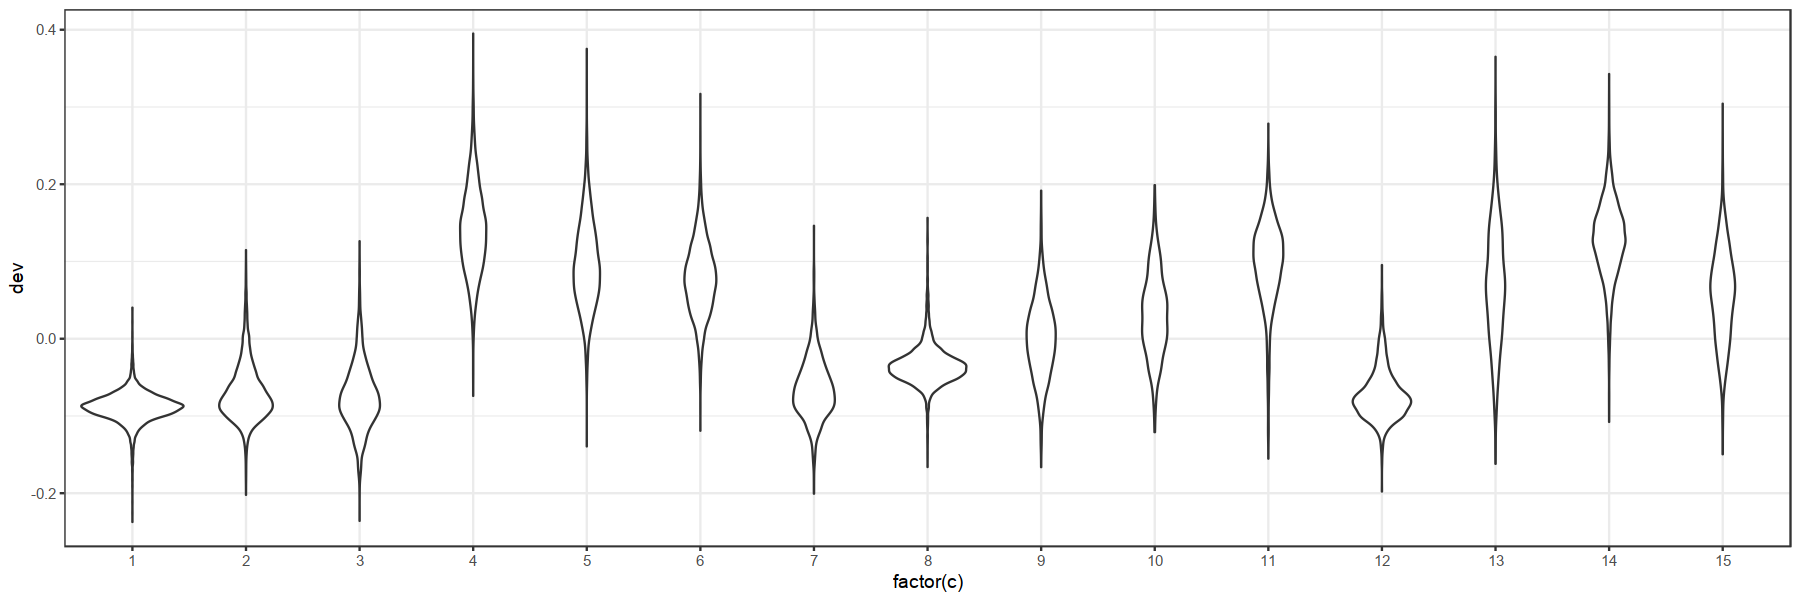

In [157]:
options(repr.plot.width = 15, repr.plot.height = 5)

ggplot(data.frame(dev=dev_mat[,"KLF4"],
                 c=metaData$cluster)) +
geom_violin(aes(x=factor(c), y=dev)) +
theme_bw()

---

In [ ]:
sessionInfo()